# Optimizers - When, Where and How to Tweak Them

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_08 import *

## Getting Imagenette Data From the DataBlock NB

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, 
        to_float_tensor]
bs = 128

img_list = ImageList.from_files(path, tfms=tfms)
split_data = SplitData.split_by_func(img_list, 
                                     partial(grandparent_splitter,
                                            valid_name='val'))

labels = label_by_func(split_data, parent_labeler, 
                       proc_y=CategoryProcessor())
data = labels.to_databunch(bs, c_in=3, c_out=10, 
                           num_workers=4)

In [5]:
# Create a model
nfs = [32, 64, 128, 256]

In [6]:
callbacks = [partial(AvgStatsCallback, accuracy),
             CudaCallback,
             partial(BatchTransformXCallback, norm_imagenette)]

In [7]:
# Baseline training with vanilla SGD
learn, run = get_learn_run(nfs, data, lr=0.4,
                          layer=conv_layer, cbs=callbacks)

In [8]:
run.fit(1, learn)

train: [1.8083522134729115, tensor(0.3725, device='cuda:0')]
valid: [2.0741764530254776, tensor(0.3251, device='cuda:0')]


## Refining the Optimizer

**`NOTES`**

- The base PyTorch optimizer in `torch.optim` is a dictionary which stores the hyper-parameters and references to the parameters of the model we want to train in parameter groups.

- It contains `step` which updates our parameters with gradients and a method `zero_grad` to detach and zero the gradients of our parameters.

- We will build a more flexible equivalent from scratch. Here, the step function loops over all the parameters to execute the step using stepper functions, which we will provide when initializing the optimizer.

- This will end up giving us parameter groups / layer groups.

In [9]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        # Could be a generator
        self.param_groups = list(params)
        # Ensuring params is a list of lists of parameter tensors
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        # Creating a dictionary for individual param groups with
        # their own references
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers)
                for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self): 
        # This step function doesn't do anything except carry out a
        # composition on items we pass on, which in turn carry out
        # their own operations. For e.g. one cycle annealing, 
        # discriminative LRs etc.
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [10]:
# To carry out SGD, via the stepper
def sgd_step(param, lr, **kwargs):
    param.data.add_(-lr, param.grad.data)
    return param

In [11]:
opt_func = partial(Optimizer, steppers=[sgd_step])

**`NOTES`**

- After changing the optimizer, we will need to adjust the callbacks which used the properties from the PyTorch optimizer.

- Hyper-parameters are in the list of dictionaries `opt.hypers`.

In [12]:
# Updating the Recorder, ParamScheduler and LR_Find classes
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train: 
            return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): 
        plt.plot(self.lrs)
        
    def plot_loss(self):
        plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])
        

class ParamScheduler(Callback):
    _order = 1
    
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, listify(sched_funcs)
    
    def begin_batch(self):
        if not self.in_train:
            return
        fs = self.sched_funcs
        if len(fs)==1: 
            fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs / self.epochs
        for f, h in zip(fs, self.opt.hypers):
            h[self.pname] = f(pos)
                

class LR_Find(Callback):
    _order = 1
    def __init(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: 
            return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr) ** pos
        for pg in self.opt.hypers:
            pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss:
            self.best_loss = self.loss
        

In [13]:
# Checking to see if the param scheduler and the recorder are working properly
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

callbacks = [partial(AvgStatsCallback, accuracy),
             CudaCallback, Recorder, 
             partial(ParamScheduler, 'lr', sched)]

In [14]:
learn, run = get_learn_run(nfs, data, lr=0.4, layer=conv_layer,
                           cbs=callbacks, opt_func=opt_func)

In [15]:
%time run.fit(1, learn)

/home/bilal/Desktop/Code Bank/ML Library/fastai_test_implement/pytorch_NN_mechanics/exp/nb_05.py:37: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx = (pos >= pcts).nonzero().max()


train: [1.8273170592855634, tensor(0.3671, device='cuda:0')]
valid: [1.442570909633758, tensor(0.5090, device='cuda:0')]
CPU times: user 8.21 s, sys: 399 ms, total: 8.61 s
Wall time: 9.8 s


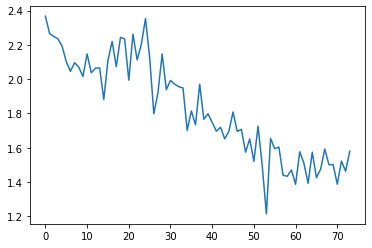

In [16]:
# Plotting loss
run.recorder.plot_loss()

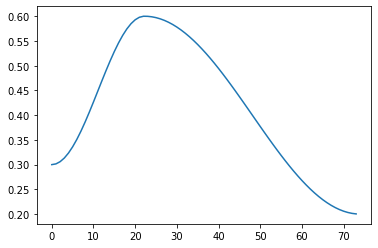

In [17]:
# Plotting LR
run.recorder.plot_lr()

## Implementing Weight Decay

**`NOTES`**

- In order to avoid over-fitting we will implement L2 regularization which is commonly known as weigth decay. Here we will be adding the sum of all the weights squared to our loss function. Doing this will ensure that the weights remain as small as possible when we compute the gradients.

- Limiting the weights from growing at a high rate is going to hinder the training of the model, but it yeilds a state where it generalizes better.

- Weight decay is a parameter that controls the sum of squares we add to our loss:
```python
loss_with_wd = loss + (wd/2) * (weights**2).sum()
```

- In practice it would be very inefficient to compute that big sum and add it to the loss. Alternatively, adding the big sum to our loss is the same as doing:
```python
weight.grad += wd * weight
```

- For every weight in our vanilla SGD is equivalent to updating the parameters with:
```python
wigh5t = weight - lr * (weight.grad + wd*weight)
```

- This results in the "decay" of each weight by a factor `lr * wd`. However, this only works for standard SGD, as we have seen with momentum, RMSProp and Adam, the update has some additional formulas around the gradient. In those cases the formula that comes from L2 regularization is:
```python
weight.grad += wd * weight
```
becomes different than weight decay
```python
new_weight = weight - lr * weight.grad - lr * wd * weight
```

- It should be noted that most libraries use the first formula, but as pointed out in the paper [Decoupled Weight Regularization](https://arxiv.org/pdf/1711.05101.pdf), it is better to use the second one with the Adam optimizer.


In [18]:
def weight_decay(param, lr, wd, **kwargs):
    param.data.mul_(1 - lr*wd)
    return param

weight_decay._defaults = dict(wd=0.)

In [19]:
# L2 regularization adds wd*weight to the gradients
def l2_regularization(param, lr, wd, **kwargs):
    param.grad.data.add_(wd, param.data)
    return param

l2_regularization._defaults = dict(wd=0.)

In [20]:
# Allowing the steppers to add to our default hyper param values
# The helper function adds in 'dest' the key/values it finds while going
# through `os` and applying `f` when there was no `key` of the same name
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest:
                dest[k] = v
                
def get_defaults(d):
    return getattr(d, '_defaults', {})

 - The optimizer remains mostly the same as before, we only take the default values of the steppers when none are provided in the kwargs.

In [21]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): 
            self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): 
            compose(p, self.steppers, **hyper)

In [22]:
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [23]:
learn, run = get_learn_run(nfs, data, lr=0.4, layer=conv_layer,
                           cbs=callbacks, opt_func=sgd_opt)

In [24]:
# Before training let's check whether everythign works as intended
# If we dont't provide a value for 'wd', we will pull the corresponding
# default from 'weight_decay'
model = learn.model

In [25]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [26]:
# Now, when we provide a value, it overrides the default
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 0.0001)
test_eq(opt.hypers[0]['lr'], 0.1)

In [27]:
# Applying what we have built to our model
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback]

In [28]:
learn, run = get_learn_run(nfs, data, 0.3, layer=conv_layer,
                          cbs=callbacks, opt_func=partial(sgd_opt, wd=0.01))

In [29]:
%time run.fit(1, learn)

train: [1.7987254049398036, tensor(0.3771, device='cuda:0')]
valid: [1.5644678045382165, tensor(0.4759, device='cuda:0')]
CPU times: user 8.21 s, sys: 418 ms, total: 8.63 s
Wall time: 9.66 s


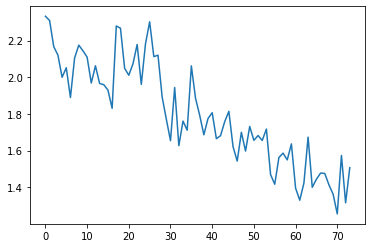

In [30]:
run.recorder.plot_loss()

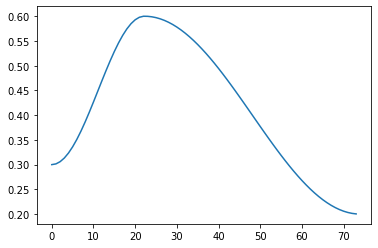

In [31]:
run.recorder.plot_lr()

**We've already improved the baseline!!**

## Adding Momentum to the Optimizer

**`NOTES`**

- The key factor in adding Momentum to the optimzer is adding some state.

- Moving averages of the gradients need to be saved and stored inside the optimizer state.

- To do this, we will be adding statistics. These are objects with two methods i.e. `init_state` which returns the initial state (a tensor of 0. for the moving average of gradients) and `update`, which updates the state with the new gradient value.

- `_defaults` will also be read to provide default values to hyper-parameters.

In [32]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults):
        self.stats = listify(stats)
        maybe_update(self.stats, defaults, get_defaults)
        super().__init__(params, steppers, **defaults)
        self.state = {}
        
    def step(self):
        for param, hyper in self.grad_params():
            if param not in self.state:
                # Create a state for param and call the statistics to initialize it
                self.state[param] = {}
                maybe_update(self.stats, self.state[param],
                             lambda o: o.init_state(param))
            state = self.state[param]
            for stat in self.stats:
                state = stat.update(param, state, **hyper)
            compose(param, self.steppers, **state, **hyper)
            self.state[param] = state

In [33]:
# Stats, at least the way they work and are updated, resemble steppers 
class Stat():
    _defaults = {}
    def init_state(self, param):
        raise NotImplementedError
    
    def update(self, param, state, **kwargs):
        raise NotImplementedError

In [34]:
# We will use momentum as an example of adding Stats
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def init_state(self, param):
        return {'grad_avg': torch.zeros_like(param.grad.data)}
    
    def update(self, param, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(param.grad.data) #this is momentum as per the definition
        return state

In [35]:
# Creating the momentum step.
def momentum_step(param, lr, grad_avg, **kwargs):
    param.data.add_(-lr, grad_avg)
    return param

In [36]:
sgd_mom_opt = partial(StatefulOptimizer, steppers=[momentum_step, weight_decay],
                      stats=AverageGrad(), wd=0.01)

In [37]:
learn, run = get_learn_run(nfs, data, lr=0.3, layer=conv_layer,
                          cbs=callbacks, opt_func=sgd_mom_opt)

In [38]:
run.fit(1, learn)

train: [2.2206936368016685, tensor(0.2730, device='cuda:0')]
valid: [1.9056349522292995, tensor(0.3389, device='cuda:0')]


### Quick Momentum Experiments

- Here, we will try to figure out what momentum actually does to the gradients by generating some plots.

In [39]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5, 0.7, 0.9, 0.999]

In [40]:
def plot_momentum(f):
    _, axs = plt.subplots(2, 2, figsize=(12,8))
    for beta, ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg, res = None, []
        for i, yi in enumerate(y):
            avg, param = f(avg, beta, yi, i)
            res.append(param)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

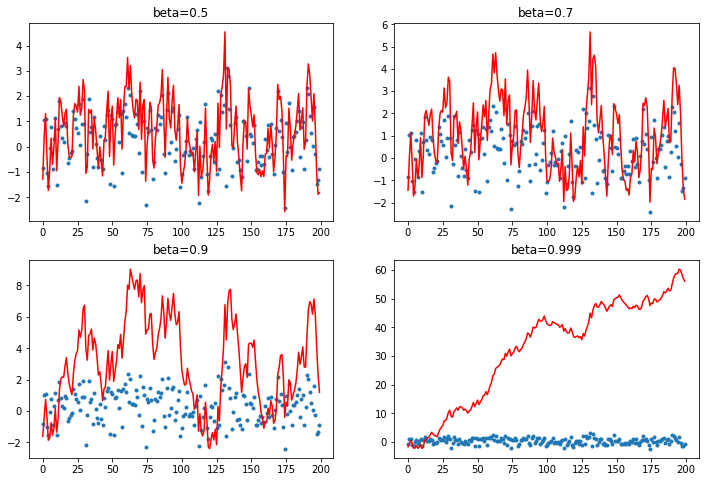

In [41]:
# Using regular momentum
def mom1(avg, beta, yi, i):
    if avg is None:
        avg = yi
    res = beta*avg + yi
    return res, res

plot_momentum(mom1)

In [42]:
# Regular momentum can easily cause the results to diverge, especially if the value is
# too high.
# A better way to smooth noisy data is to do an exponentially weighted moving average.
# Here there is a dampening of (1-beta) in front of the new value. We will define
# lin_comb(linear combination) to make this easier.
def lin_comb(v1, v2, beta):
    return beta*v1 + (1-beta)*v2 

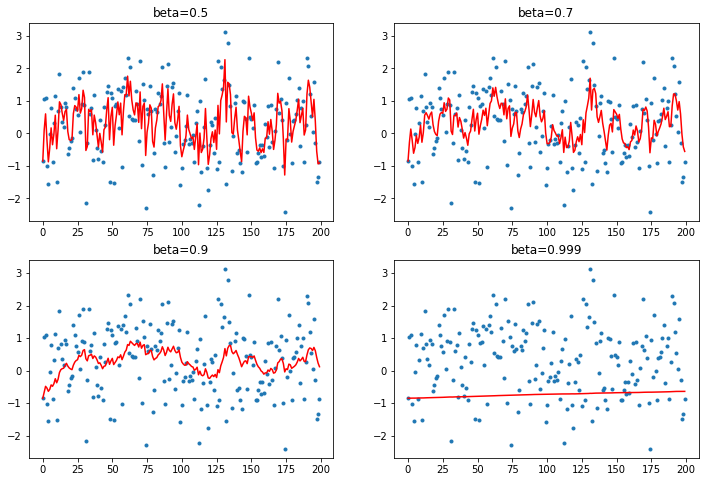

In [43]:
def momentum2(avg, beta, yi, i):
    if avg is None: 
        avg=yi
    avg = lin_comb(avg, yi, beta)
    return avg, avg

plot_momentum(momentum2)

 - This is the result when our data is purely random. If it has a certain shape, then it will get that shape, but with a delay for high beta.

In [44]:
y = 1 - (x/3)**2 + torch.randn(200)*0.1

In [45]:
y[0] = 0.5

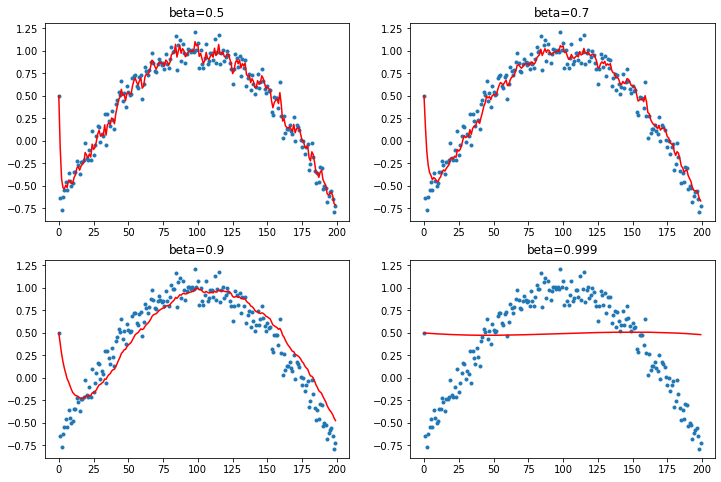

In [46]:
plot_momentum(momentum2)

- In the case of beta=0.999, item 1 is massively biasing the start of optimizing.

- We will now introduce debiasing. Basically, we will be dividing our moving average with sum of the coefficients:
$\begin{align*}
S = 1 - \beta^{i+1}
\end{align*}$

- By dividing by this term, we make our moving average a true average (all coefficients we used for the average sum up to 1).


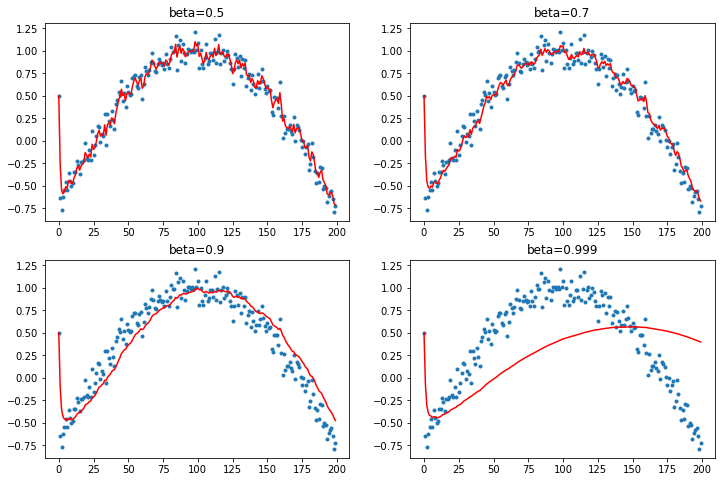

In [47]:
def momentum3(avg, beta, yi, i):
    if avg is None:
        avg = 0
    avg = lin_comb(avg, yi, beta)
    return avg, avg / (1-beta**(i+1))

plot_momentum(momentum3)

## Introducing Adam

- With Adam, we use the gradient averages with dampening which won't be the same as SGD with momentum.

In [48]:
# Making the necessary changes to AverageGrad
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening: bool=False):
        self.dampening=dampening
    
    def init_state(self, param):
        return {'grad_avg': torch.zeros_like(param.grad.data)}
    
    def update(self, param, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], param.grad.data)
        return state

In [49]:
# We will also need to track the moving average of the gradients squared.
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True):
        self.dampening = dampening
        
    def init_state(self, param):
        return {'sqr_avg': torch.zeros_like(param.grad.data)}
    
    def update(self, param, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1-sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], 
                                                param.grad.data, param.grad.data)
        return state

In [50]:
# We will also need the number of steps done during training for debiasing.
class StepCount(Stat):
    def init_state(self, param):
        return {'step': 0}
    
    def update(self, param, state, **kwargs):
        state['step'] += 1
        return state

In [51]:
# This helper function computes the debias term. If we're dampening then 'damp = 1-mom'
# while if we're not dampening `damp=1`,we will need to divide by '1-mom' since that
# term is missing in every calculation.
def debias(mom, damp, step):
    return damp * (1 - mom**step) / (1 - mom)

In [66]:
# This is the Adam step
def adam_step(param, lr, mom, mom_damp, step, sqr_mom, sqr_damp,
              grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    param.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps) # epsilon goes outside, discussion on forum
    return param

adam_step._defaults = dict(eps=1e-5)

In [67]:
def adam_opt(extra_step=None, **kwargs):
    return partial(StatefulOptimizer, 
                   steppers=[adam_step, weight_decay]+listify(extra_step),
                   stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()],
                   **kwargs)

In [68]:
learn, run = get_learn_run(nfs, data, lr=0.0015, layer=conv_layer, cbs=callbacks,
                          opt_func=adam_opt())

In [69]:
run.fit(5, learn)

train: [6.358463307899461, tensor(0.1517, device='cuda:0')]
valid: [2040.1230573248408, tensor(0.1949, device='cuda:0')]
train: [2.208522340994297, tensor(0.2519, device='cuda:0')]
valid: [29771.78904458599, tensor(0.1325, device='cuda:0')]
train: [1.9551065895949942, tensor(0.3275, device='cuda:0')]
valid: [894.1989808917198, tensor(0.2285, device='cuda:0')]
train: [1.8080919068143415, tensor(0.3770, device='cuda:0')]
valid: [1560239.058343949, tensor(0.3450, device='cuda:0')]
train: [1.6681994576050798, tensor(0.4335, device='cuda:0')]
valid: [269292.6287898089, tensor(0.1032, device='cuda:0')]


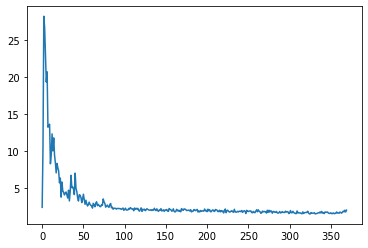

In [70]:
run.recorder.plot_loss()

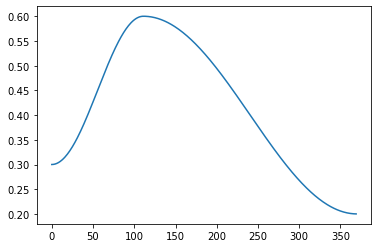

In [71]:
run.recorder.plot_lr()

## Introducing the LAMB Optimizer

$\begin{align}
g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\  
v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
\end{align}$

_Steps 2 and 3 are exponentially weighted moving averages, where 2 has a gradient and 
3 has a gradient squared (element wise multiplication)_

$\begin{align}
m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
\end{align}$

_The two previous steps indicate debiasing for both **m** and **v**._

$\begin{align}
r_{1} &= \|w_{t-1}^{l}\|_{2} \\
\end{align}$

_This is the norm of the weights / weight decay._

$\begin{align}
s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l} + \epsilon}} + \lambda w_{t-1}^{l} \\ 
r_{2} &= \| s_{t}^{l} \|_{2} \\
\end{align}$

_This is the Adam step, followed by the norm of the Adam step._

$\begin{align}
\eta^{l} &= \eta * r_{1}/r_{2} \\ 
w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
\end{align}$

In [76]:
# Implementing the code of the LAMB optimizer
def lamb_step(param, lr, mom, mom_damp, step, sqr_mom, 
              sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom, mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = param.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt() + eps) + wd*param.data
    r2 = step.pow(2).mean().sqrt()
    param.data.add_(-lr * min(r1/r2, 10), step)
    return param

lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [77]:
lamb = partial(StatefulOptimizer, steppers=lamb_step, 
               stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [82]:
learn, run = get_learn_run(nfs, data, lr=0.003, layer=conv_layer,
                           cbs=callbacks, opt_func=lamb)

In [83]:
run.fit(5, learn)

train: [18.000442232548316, tensor(0.1366, device='cuda:0')]
valid: [5854.941146496815, tensor(0.1208, device='cuda:0')]
train: [790.0974231703453, tensor(0.1090, device='cuda:0')]
valid: [1647.312738853503, tensor(0.0948, device='cuda:0')]
train: [314.08662477558346, tensor(0.1018, device='cuda:0')]
valid: [120.26621815286624, tensor(0.1032, device='cuda:0')]
train: [74.61892095258212, tensor(0.1065, device='cuda:0')]
valid: [40.17158439490446, tensor(0.1034, device='cuda:0')]
train: [19.531165843806104, tensor(0.1071, device='cuda:0')]
valid: [24.949490445859873, tensor(0.1134, device='cuda:0')]


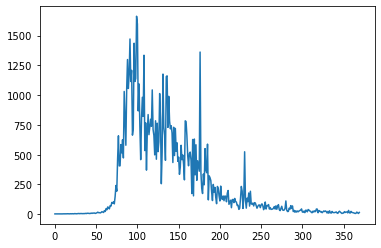

In [85]:
run.recorder.plot_loss()

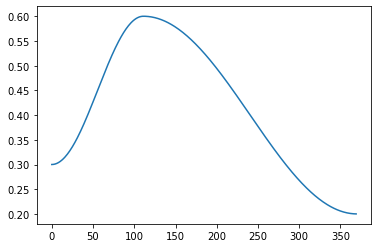

In [86]:
run.recorder.plot_lr()

Other recent variants of optimizers:
- [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888) (LARS also uses weight statistics, not just gradient statistics. Can you add that to this class?)
- [Adafactor: Adaptive Learning Rates with Sublinear Memory Cost](https://arxiv.org/abs/1804.04235) (Adafactor combines stats over multiple sets of axes)
- [Adaptive Gradient Methods with Dynamic Bound of Learning Rate](https://arxiv.org/abs/1902.09843)